# Street View House Numbers (SVHN) with VAE and GAN

In [17]:
import torch
import os
import torchvision
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision.transforms import ToTensor, Lambda, Grayscale, Compose, Resize
from torchvision import transforms, datasets
from torchvision.datasets import FashionMNIST, ImageFolder
from matplotlib import pyplot as plt
import torchvision.utils as vutils
import numpy as np
import pickle as pkl
import matplotlib.animation as animation


import numpy as np

%matplotlib inline

In [18]:
IMG_WIDTH = 32
IMG_HEIGHT = 32
batch_size = 128
IMGS_TO_VISUALIZE = 4
d = 20 # Latent Dimension
dataset_path = "../data" 

# Set random seeds for reproducibility

torch.manual_seed(1)
torch.cuda.manual_seed(1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [19]:
IMAGE_SIZE = 32


transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])    

svhn_train = datasets.SVHN(root='../data', split='train', download=True, transform=transform)
svhn_test = datasets.SVHN(root='../data', split='test', download=True, transform=transform)

batch_size = 256
num_workers = 0


train_loader = torch.utils.data.DataLoader(dataset=svhn_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset=svhn_test,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)

Using downloaded and verified file: ../data\train_32x32.mat
Using downloaded and verified file: ../data\test_32x32.mat


## VAE for SVHN

In [20]:
class VAE_SVHN(nn.Module):
    def __init__(self, img_width, img_height):
        super().__init__()
        
        self.img_width = img_width
        self.img_height = img_height

        self.encoder = nn.Sequential(
            nn.Linear(img_width * img_height * 3, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, img_width * img_height * 3),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        
        x = x.view(-1, 3 * self.img_width * self.img_height) # Flatten in case it is not already
        
        mu_logvar = self.encoder(x)        
        mu_logvar = mu_logvar.view(-1, 2, d) # divide dimensions to get mu and variance # [batch_size, d * 2] -> [batch_size, 2, d] 
        mu = mu_logvar[:, 0, :] # mean
        logvar = mu_logvar[:, 1, :] # variance
        
        z = self.reparameterise(mu, logvar) # create the latent representation based on mu and variance
        
        return self.decoder(z), mu, logvar

In [21]:
model = VAE_SVHN(IMG_WIDTH,IMG_HEIGHT).to(device)
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

model

VAE_SVHN(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=3072, bias=True)
    (3): Sigmoid()
  )
)

In [22]:
def loss_function(x_hat, x, mu, logvar):
    
    # Reconstruction loss
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, IMG_WIDTH * IMG_HEIGHT * 3), reduction='sum'
    )
    
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #KL-Divergence loss

    return BCE + KLD

In [23]:
def train(num_epochs = 5):
    
    imgs = []
    generated_imgs = []
    test_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
        
        # Testing
    
        with torch.no_grad():
            model.eval()
            test_loss = 0
            for x, _ in test_loader:
                x = x.to(device)
                # ===================forward=====================
                x_hat, mu, logvar = model(x)
                test_loss += loss_function(x_hat, x, mu, logvar).item()
                
        # ===================log========================
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print(f'====> Test set loss: {test_loss:.4f}')
          
        # Print imgs if wanted
        x_hat = x_hat.view(-1, 3, IMG_HEIGHT, IMG_WIDTH)
        imgs.append(torch.cat([x[:IMGS_TO_VISUALIZE], x_hat[:IMGS_TO_VISUALIZE]], dim = 0))
        generated_imgs.append(x_hat)
    
    concat_imgs = torch.cat([tens for tens in imgs])
    return mu, logvar, x, concat_imgs, test_losses, generated_imgs

In [24]:
mu, logvar, x, imgs, losses, generated_imgs = train(20) # Get mu, variance, and last input to the network to test after!

====> Epoch: 0 Average loss: -33469.5844
====> Test set loss: -41933.0308
====> Epoch: 1 Average loss: -38155.6915
====> Test set loss: -46722.8078
====> Epoch: 2 Average loss: -39977.3571
====> Test set loss: -46196.7218
====> Epoch: 3 Average loss: -40785.0792
====> Test set loss: -50898.7457
====> Epoch: 4 Average loss: -41625.3923
====> Test set loss: -46796.8950
====> Epoch: 5 Average loss: -42900.1702
====> Test set loss: -45074.3454
====> Epoch: 6 Average loss: -44048.6205
====> Test set loss: -51481.0192
====> Epoch: 7 Average loss: -44696.1845
====> Test set loss: -51585.8767
====> Epoch: 8 Average loss: -45498.1845
====> Test set loss: -53322.1989
====> Epoch: 9 Average loss: -46570.2669
====> Test set loss: -51435.9291
====> Epoch: 10 Average loss: -47394.9663
====> Test set loss: -53108.6281
====> Epoch: 11 Average loss: -48284.2811
====> Test set loss: -52719.8791
====> Epoch: 12 Average loss: -49104.7865
====> Test set loss: -54096.2920
====> Epoch: 13 Average loss: -4977

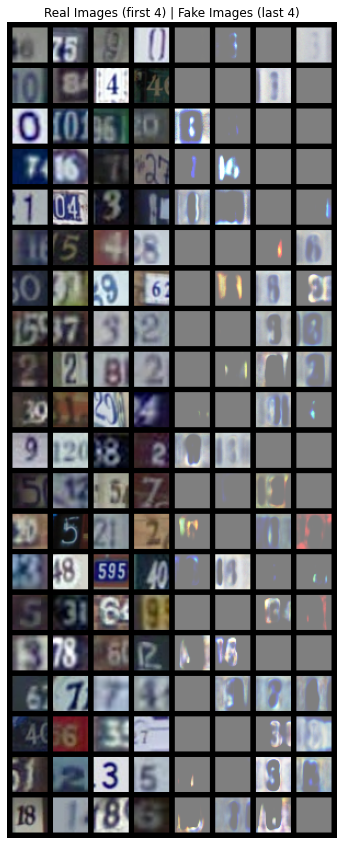

In [25]:
# Plot what was generated and what 

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images (first 4) | Fake Images (last 4)")
plt.imshow(np.transpose(vutils.make_grid(imgs, padding=5, normalize=True, nrow=IMGS_TO_VISUALIZE * 2).cpu(),(1,2,0))) 

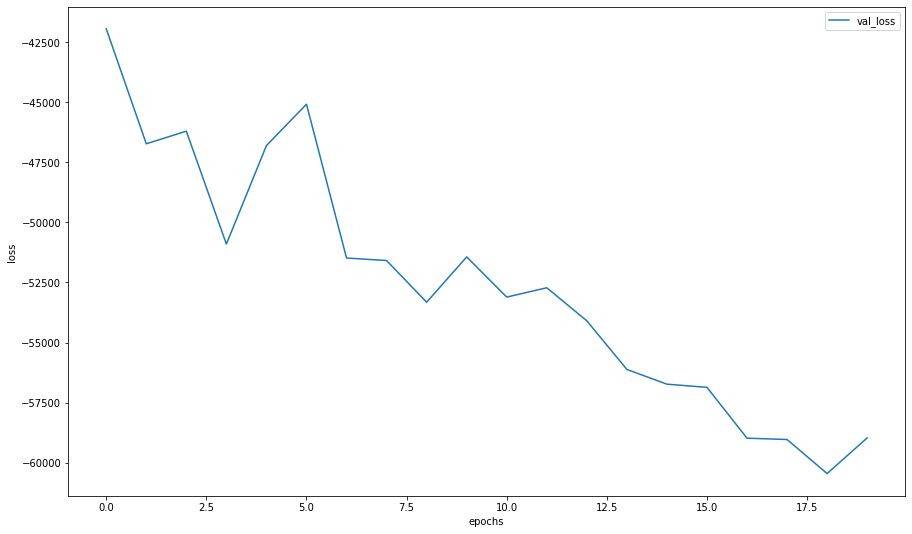

In [26]:

plt.figure(figsize=(15, 9))
plt.plot(losses, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

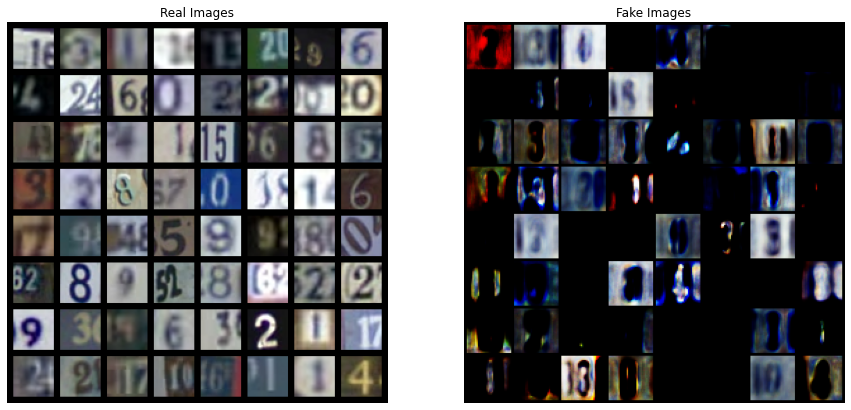

In [49]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(test_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(
    vutils.make_grid(generated_imgs[-1][-64:].cpu(), padding=2, normalize=True), (1,2,0)
    ))
plt.show()